In [1]:
#import standard_hopfield as sh
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, njit
import time
import math
from scipy import optimize
from scipy.optimize import curve_fit, fsolve
from scipy import stats
from sklearn.linear_model import LinearRegression

We define the critical probability as
$$
p_c(N, \alpha) := \left\{p: \mathbb{P}^{reconst}_{N, \alpha}(p) = \frac{1}{2} \right\},
$$
that is, the corruption probability such that the reconstruction probability is equal to 0.5. <br>
Thus, taking the $\lim_{N \to \infty}$, we define:
$$
p_c(\alpha) = \lim_{N \to \infty} p_c(N, \alpha).
$$
Assuming that $ p_c(N, \alpha) \sim 1/N $, i.e.
$$
p_c(N, \alpha) = p_c(\alpha) + \frac{1}{N} p_c(\alpha) + o\left(\frac{1}{N^2}\right)
$$
**our goal is to determine $p_c(\alpha)$**.<br>
In order to achieve this, we need to fit the $\mathbb{P}^{reconst}_{N, \alpha}(p)$ function:
$$
\mathbb{P}^{reconst}_{N, \alpha}(p) = exp[q_{N, \alpha} + {a_{N, \alpha}p + b_{N, \alpha} p^2 + c_{N, \alpha} p^3} + d_{N, \alpha} p^4]
$$

In [22]:
def reg_func(x, q, a, b): return q + a*x**(-1) + b*x**(-2)
    

def plotfit(pp, N, P_N, popt):
    fig = plt.figure(figsize = (6, 5))
    plt.plot(pp, P_N, label = "simulation", marker = "o", color = "black", linestyle = "None", markerfacecolor = "None")
    plt.plot(pp, np.exp(popt[0] + popt[1] * pp + popt[2] * pp**2 + popt[3] * pp**3 + popt[4] * pp**4),
             label = "fit", color = "red", linewidth = 1.)
    plt.ylabel("P_reconst", size = 12)
    plt.xlabel("p", size = 12)
    plt.title("N = {}".format(N), size = 12)
    plt.legend()
    plt.grid(axis = "both", linestyle = "--", alpha = 0.5)
    plt.show()

def plotreg(N_reciproc, pcN, popt):
    fig = plt.figure(figsize = (7,5))
    plt.plot(N_reciproc, pcN, c = "black", marker = "o", markerfacecolor = "None",
             linewidth = 1., linestyle = "None", label = r"experimental $p_c(N, \alpha = 0.1)$")
    plt.plot(N_reciproc, popt[0] + popt[1]*N_reciproc + popt[2] * N_reciproc**2, linestyle = "--", c = "red",
             linewidth = 1., label = r"intercept $p_c(\alpha = 0.1) \sim$ {}".format(round(popt[0], 3)))
    #plt.xlabel(r"1/$\sqrt{N}$", size = 12)
    plt.ylabel(r"$p_c(N, \alpha = 0.1)$", size = 12)
    plt.grid(axis = "both", linestyle = "--", alpha = 0.5)
    plt.title("Finite size scaling", size = 12)
    plt.legend(fontsize = 12)
    plt.show()

In [31]:
def P_rec(p, q, a, b, c, d): return np.exp(q + a * p + b * p**2 + c * p**3 + d * p**4)

def compute_pc(α, NN, plot_fit = False, plot_reg = False, thr = 0.5):
    
    pcN = []
    folder = str(α).replace(".", "")
    pp = np.loadtxt("julia_data/new/alpha_"+folder+"/probsN{}.txt".format(NN[0]), delimiter = "\t")[:, 0]
    for N in NN:
        
        P_N = np.loadtxt("julia_data/alpha_01/probsN{}.txt".format(N), delimiter = "\t")[:, 1]
        popt, pcov = curve_fit(P_rec, pp, P_N)
        
        if plot_fit: plotfit(pp, N, P_N, popt)                        
        
        # find the value of p that makes P_rec = 0.5
        sol = optimize.root_scalar(lambda p: np.exp(popt[0] + popt[1] * p +
                                                    popt[2] * p**2 + popt[3] * p**3 + popt[4] * p**4) - thr,
                           x0 = 0.3, bracket = [0.15, 0.35], method='brentq')
        
        pcN.append(sol.root)
    
    pcN = pcN#[::-1]
    N_reciproc = np.array(list(map(lambda n: 1/n, NN)))#[::-1]
    popt, pcov = curve_fit(reg_func, NN, pcN)
    
    if plot_reg: plotreg(N_reciproc, pcN, popt)
        
        
    return pcN, popt[0]
    


## $p_c$ for $\alpha$ = 0.1

In [29]:
NN = [50, 100, 150, 200, 250, 700, 1000]
#NN = [50, 100, 200, 250, 500]

α = 0.1
a = compute_pc(α, NN, plot_fit= True, plot_reg = True)

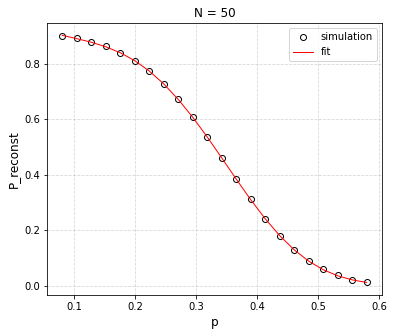

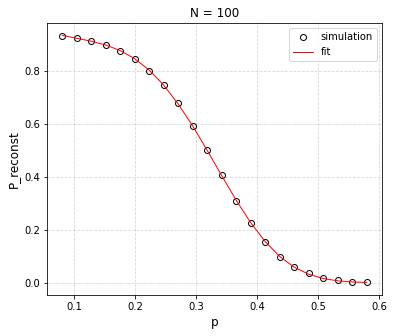

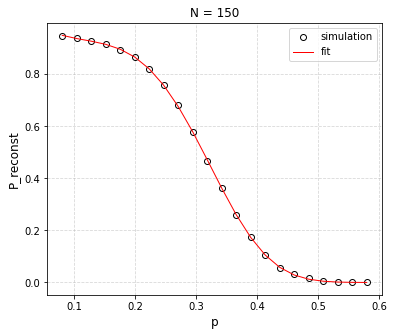

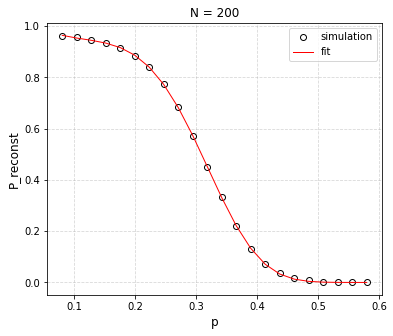

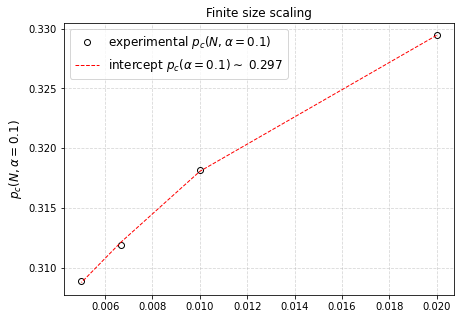

In [32]:
NN = [50, 100, 150, 200]
#NN = [50, 100, 200, 250, 500]

α = 0.1
a = compute_pc(α, NN, plot_fit= True, plot_reg = True)